In [1]:
import pandas as pd
import tensorflow as tf

df = pd.read_feather('data/logs.ft')

# Preprocessing

Defined `validation_pid.lst`, containing PIDs that should be added to validation set as contain redundant malicious techniques / benign activity, that will contain similar events in training set as well:
```
malicious:
8216: netstat enum
4556: powershell enc command
1580: whoami.exe /groups
2204: browser_broker embedding
1396: fodhelper (1 out of 2)

valid:
7236: edge.exe
1532: backgroundtaskhost.exe
2520: dllhost loads
8636: dllhost loads
8740: svchost.exe
```

Creating train/val sets from df.

In [19]:
import re
def preprocess_df(df):
    fields = ['UtcTime', 'ProcessId', 'EventID', 'User', 'Image', 'ImageLoaded', 'CommandLine',             'ParentImage', 'ParentCommandLine', 'DestinationPort', 'Protocol', 'QueryName', 'TargetFilename', 'TargetObject', 'raw']
    newdf = df[fields]

    # drop all records where ProcessId in NaN (happens for WMI events, cannot classify [TODO: think how to overcome and add to dataset])
    newdf = newdf[~newdf.ProcessId.isna()]

    # drop EventID 5 - ProcessTerminated as not valuable
    newdf.drop(newdf[newdf.EventID == '5'].index, inplace=True)

    # get binary name (last part of "Image" after "\")
    newdf['binary'] = newdf.Image.str.split(r'\\').apply(lambda x: x[-1].lower())

    # same with binary pathes
    newdf['path'] = newdf.Image.str.split(r'\\').apply(lambda x: '\\'.join(x[:-1]).lower())

    newdf['arguments'] = newdf.CommandLine.fillna('empty').str.split().\
                                                            apply(lambda x: ' '.join(x[1:]))


    # add new features whether suspicious string are in arguments?
    # 1. base64?
    # will match at least 32 character long consequent string with base64 characters only
    b64_regex = r"[a-zA-Z0-9+\/]{64,}={0,2}"

    # map this search as 0 and 1 using astype(int)
    b64s = newdf['arguments'].apply(lambda x: re.search(b64_regex, x)).notnull()
    newdf['b64'] = b64s.astype(int)

    # matches if there's call for some file with extension (at the end dot) via UNC path
    unc_regex = r"\\\\[a-zA-Z0-9]+\\[a-zA-Z0-9\\]+\."
    uncs = newdf['arguments'][newdf['arguments'].apply(lambda x: re.search(unc_regex, x)).notnull()]

    url_regex = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    urls = newdf['arguments'].apply(lambda x: re.search(url_regex, x)).notnull()

    # verified pd.concat part - merges two boolean series correctly
    newdf['unc_url'] = pd.concat([uncs, urls]).astype(int)

    newdf['network'] = newdf['Protocol'].notnull().astype(int)

    newdf = newdf[['ProcessId','binary','EventID','path', 'unc_url', 'b64', 'network']]
    # treat eventID as int8
    newdf['EventID'] = newdf['EventID'].astype('int8')
    return newdf

In [20]:
new_df = preprocess_df(df)

MAX_TIMESTEPS = 128
# number of features (except ProcessId itself)
N = len(new_df.columns) - 1

In [18]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from datetime import datetime
import numpy as np

def groupby_transform(dataframe, column):
    global MAX_TIMESTEPS, N
    total = len(dataframe.groupby(column))
    start = datetime.now()
    print(f"Started at: {start}")

    print(f"Total categories of '{column}': '{total}'")
    print(f"Unique values: {dataframe[column].nunique()}")

    # Initialize Numpy Arrays with correct shape
    train_X = np.empty(shape=(0, MAX_TIMESTEPS, N)).astype(np.int16)
    train_y = np.empty(shape=(0,1)).astype(np.int16)
    val_X = np.empty(shape=(0, MAX_TIMESTEPS, N)).astype(np.int16)
    val_y = np.empty(shape=(0,1)).astype(np.int16)

    # get encode object for string columns
    binary_le = LabelEncoder().fit(['OTHER'] + list(dataframe['binary'].unique()))
    path_le = LabelEncoder().fit(['OTHER'] + list(dataframe['path'].unique()))
    
    # load malicious/valid process lists
    with open(r'data/pid_valid.lst') as f:
        valid_lst = [x.strip() for x in f.readlines()]
    with open(r'data/pid_malicious.lst') as f:
        mal_lst = [x.strip() for x in f.readlines()]
    
    with open(r'data/validation_pid.lst') as f:
        validation_data = f.readlines()

    validation_pids = []
    for line in validation_data:
        if ':' in line:
            validation_pids.append(line.split(':')[0])

    try:
        for i, (value, df) in enumerate(dataframe.groupby(column)):
            # skip processes with less than 3 events 
            # - too little to identify malicious activity
            if len(df) < 4:
                continue
            
            if value in valid_lst:
                temp_y = np.array([0]).reshape(1,1)
            elif value in mal_lst:
                temp_y = np.array([1]).reshape(1,1)
            else:
                print(f'Unclassified ProcessID: {value}')
                raise Exception

            # Create 3D array from 
            temp_X = np.hstack((
                df[['EventID', 'unc_url', 'b64', 'network']].to_numpy(),
                binary_le.transform(list(df['binary'])).reshape(-1,1),
                path_le.transform(list(df['path'])).reshape(-1,1)
            ))

            # PADDING
            temp_X = pad_sequences(temp_X.T, maxlen=MAX_TIMESTEPS).T
            
            # adding this example to actual set
            if value in validation_pids:
                val_X = np.concatenate((val_X, temp_X.reshape(1, MAX_TIMESTEPS, N)))
                val_y = np.concatenate((val_y, temp_y))
            else:
                train_X = np.concatenate((train_X, temp_X.reshape(1, MAX_TIMESTEPS, N)))
                train_y = np.concatenate((train_y, temp_y))
        
        end = datetime.now()
        print(f"Ended at: {end}")
        print(f"Script completion time: {end - start}")
        return train_X, val_X, train_y, val_y

    except KeyboardInterrupt:
        end = datetime.now()
        print(f"Ended at:\niteration:{i}\ntime:{end}")
        print(f"Script completion time: {end - start}")
        return train_X, val_X, train_y, val_y

    #except Exception as ex:
    #    print(ex)
    #    np.save(f'X{i}.npy', X)
    #    np.save(f'y{i}.npy', y)

In [21]:
train_X, val_X, train_y, val_y = groupby_transform(new_df, 'ProcessId')

Started at: 2020-07-02 14:33:05.285077
Total categories of 'ProcessId': '93'
Unique values: 93
Ended at: 2020-07-02 14:33:05.389800
Script completion time: 0:00:00.104723


In [22]:
print(train_X.shape)
print(val_X.shape)
print(train_y.shape)
print(val_y.shape)

(70, 128, 6)
(10, 128, 6)
(70, 1)
(10, 1)


In [23]:
u, c = np.unique(train_y, return_counts=True)
pos, neg = c
pos, neg
print(f"Malicious processes: {neg}\nValid processes: {pos}")
print(f"Malicious percentage: {round(neg*100/(pos+neg),4)} %")

Malicious processes: 14
Valid processes: 56
Malicious percentage: 20.0 %


# Training

## Initialization

In [24]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    # Precision: (TP) / (TP + FP)
    # what proportion of predicted Positives is truly Positive
    tf.keras.metrics.Precision(name='precision'),
    # Recall: (TP) / (TP+FN)
    # what proportion of actual Positives is correctly classified
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.Accuracy(name='accuracy')
    ]

def model_conv_rnn_02(MAX_TIMESTEPS, OH_DIMENSION):
    model = tf.keras.models.Sequential([
                tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', 
                                    input_shape=[MAX_TIMESTEPS, OH_DIMENSION]),
                tf.keras.layers.MaxPooling1D(pool_size=2),
                tf.keras.layers.LSTM(64),
                tf.keras.layers.Dropout(0.2),
                tf.keras.layers.Dense(32, activation='relu'),
                tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [25]:
import matplotlib.pyplot as plt

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(epochs, history, label='', n=1, val=False):
    # Use a log scale to show the wide range of values.
    plt.semilogy(epochs,  history['loss'],
               color=colors[n], label='Train '+label)
    if val:
      plt.semilogy(epochs,  history['val_loss'],
            color=colors[n], label='Val '+label,
            linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
  
    plt.legend()

In [26]:
BATCH_SIZE = 10
SHUFFLE_BUFFER = 100

train_ds = tf.data.Dataset.from_tensor_slices((train_X, train_y)).\
                    shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((val_X, val_y)).\
                    shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(1)

## Training without `validation_data`

In [41]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

OPT = tf.keras.optimizers.Adam(learning_rate=0.005)
model3 = model_conv_rnn_02(MAX_TIMESTEPS, N)
model3.compile(optimizer=OPT, loss='binary_crossentropy', metrics=METRICS)

In [46]:
h = model3.fit(train_ds, epochs=300, verbose=0)#, validation_data=val_ds)

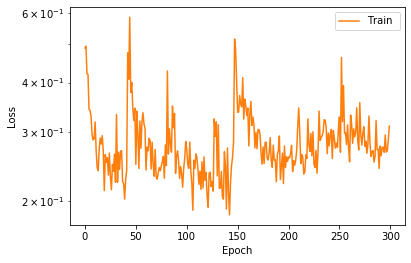

In [47]:
plot_loss(h.epoch, h.history, val=False)

In [48]:
model3.evaluate(val_ds)

1/1 [==============================] - 0s 10ms/step - loss: 1.0346 - tp: 1.0000 - fp: 0.0000e+00 - tn: 5.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.2000 - auc: 0.9200 - accuracy: 0.0000e+00


[1.034559965133667, 1.0, 0.0, 5.0, 4.0, 1.0, 0.2, 0.92, 0.0]

In [49]:
model3.evaluate(train_ds)

7/7 [==============================] - 0s 8ms/step - loss: 0.2532 - tp: 8.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.5714 - auc: 0.8699 - accuracy: 0.0000e+00


[0.25324819662741255, 8.0, 0.0, 56.0, 6.0, 1.0, 0.5714286, 0.86989796, 0.0]

## Training with `validation_data`

In [69]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

OPT = tf.keras.optimizers.Adam(learning_rate=0.005)
model3 = model_conv_rnn_02(MAX_TIMESTEPS, N)
model3.compile(optimizer=OPT, loss='binary_crossentropy', metrics=METRICS)

In [70]:
h = model3.fit(train_ds, epochs=500, verbose=0, validation_data=val_ds)

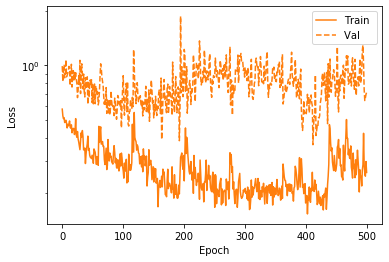

In [71]:
plot_loss(h.epoch, h.history, val=True)

In [72]:
model3.evaluate(val_ds)

1/1 [==============================] - 0s 12ms/step - loss: 0.7108 - tp: 1.0000 - fp: 0.0000e+00 - tn: 5.0000 - fn: 4.0000 - precision: 1.0000 - recall: 0.2000 - auc: 0.9200 - accuracy: 0.0000e+00


[0.7108218669891357, 1.0, 0.0, 5.0, 4.0, 1.0, 0.2, 0.92, 0.0]

In [73]:
model3.evaluate(train_ds)

7/7 [==============================] - 0s 8ms/step - loss: 0.2216 - tp: 8.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 6.0000 - precision: 1.0000 - recall: 0.5714 - auc: 0.9503 - accuracy: 0.0000e+00


[0.22159467105354583, 8.0, 0.0, 56.0, 6.0, 1.0, 0.5714286, 0.9502551, 0.0]

## Trying Early Stopping

In [87]:
es_callback = [
    tf.keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=0.05,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=200,
        verbose=1,
        restore_best_weights=True
    )
]

In [88]:
tf.keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

OPT = tf.keras.optimizers.Adam(learning_rate=0.005)
model3 = model_conv_rnn_02(MAX_TIMESTEPS, N)
model3.compile(optimizer=OPT, loss='binary_crossentropy', metrics=METRICS)

In [89]:
model3.fit(train_ds, epochs=1000, validation_data=val_ds, callbacks=es_callback)

fn: 4.0000 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.9600 - val_accuracy: 0.0000e+00
Epoch 207/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.1886 - tp: 9.0000 - fp: 0.0000e+00 - tn: 56.0000 - fn: 5.0000 - precision: 1.0000 - recall: 0.6429 - auc: 0.9688 - accuracy: 0.0000e+00 - val_loss: 0.6196 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 5.0000 - val_fn: 4.0000 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.9600 - val_accuracy: 0.0000e+00
Epoch 208/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.2306 - tp: 9.0000 - fp: 1.0000 - tn: 55.0000 - fn: 5.0000 - precision: 0.9000 - recall: 0.6429 - auc: 0.9464 - accuracy: 0.0000e+00 - val_loss: 0.7944 - val_tp: 1.0000 - val_fp: 0.0000e+00 - val_tn: 5.0000 - val_fn: 4.0000 - val_precision: 1.0000 - val_recall: 0.2000 - val_auc: 0.9600 - val_accuracy: 0.0000e+00
Epoch 209/1000
7/7 [==============================] - 0s 33ms/step - loss: 0.2030 - tp: 9.0000 - fp: 0.0000e+00 - t

In [90]:
model3.evaluate(val_ds)

1/1 [==============================] - 0s 12ms/step - loss: 0.3413 - tp: 3.0000 - fp: 0.0000e+00 - tn: 5.0000 - fn: 2.0000 - precision: 1.0000 - recall: 0.6000 - auc: 1.0000 - accuracy: 0.0000e+00


[0.3413061499595642, 3.0, 0.0, 5.0, 2.0, 1.0, 0.6, 1.0, 0.0]